In [11]:
'''
Extra Setup for Colaboratory Environment
'''
#!pip install cmake
#!pip install dlib

#from google.colab import files
#uploaded = files.upload() 

#!7za e colaboratory_dependencies.7z
#!7za x frontalization_models.7z
#!7za x dlib_models.7z

'\nExtra Setup for Colaboratory Environment\n'

In [0]:
'''
Libraries, etc.
'''
import os
import sys
import cv2
import numpy as np 
import scipy as sp
import pandas as pd 
import seaborn as sns
from math import sqrt
import scipy.io as io
import tensorflow as tf 
from pathlib import Path
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix

from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.utils import np_utils as npu
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Convolution2D, Activation, BatchNormalization, GaussianNoise, MaxPooling2D, Dropout, Dense, Flatten
  


import frontalize
import check_resources as check
import camera_calibration as calib
import facial_feature_detector as feature_detection

from models import get_model1, get_model2, get_model3

#this_path = os.path.dirname(os.path.abspath(__file__)) 
this_path = str(Path().resolve()) # for Colaboratory

In [0]:
'''
Constants, Hyperparameters, etc.
'''
BATCH_SIZE = 128
NUM_EPOCHS = 128

input_file = 'fer2013.csv'
filepath = 'Model.{epoch:02d}-{val_acc:.4f}.hdf5'

model1_acc_file = "acc_model1_t2.png"
model2_acc_file = "acc_model2_t2.png"
model3_acc_file = "acc_model3_t2.png"
acc_file = model1_acc_file

model1_loss_file = "loss_model1_t2.png"
model2_loss_file = "loss_model2_t2.png"
model3_loss_file = "loss_model3_t2.png"
loss_file = model1_loss_file

model1_cm_file = "cm_model1_t2.png"
model2_cm_file = "cm_model2_t2.png"
model3_cm_file = "cm_model3_t2.png"
cm_file = model1_cm_file

emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
num_classes = len(emotion_labels)

In [26]:
'''
Load & Parse Data into Training/Test Labels & Images
'''
data = pd.read_csv(input_file)
data.head()

# get data and labels
train_set = data[(data.Usage == 'Training')]
validation_set = data[(data.Usage == 'PublicTest')]
test_set = data[(data.Usage == 'PrivateTest')]

# greyscale so depth 1
depth = 1
height = int(sqrt(len(data.pixels[0].split())))
width = height

# from pandas to np array
X_train = np.array(list(map(str.split, train_set.pixels)), np.uint8)
X_validation = np.array(list(map(str.split, validation_set.pixels)), np.uint8)
X_test = np.array(list(map(str.split, test_set.pixels)), np.uint8)

# reshape data
num_train = X_train.shape[0]
num_validation = X_validation.shape[0]
num_test = X_test.shape[0]

X_train = X_train.reshape(num_train, width, height, depth)
X_validation = X_validation.reshape(num_validation, width, height, depth)
X_test = X_test.reshape(num_test, width, height, depth)

y_train = train_set.emotion
y_validation = validation_set.emotion
y_test = test_set.emotion

y_train = np_utils.to_categorical(y_train, num_classes)
y_validation = np_utils.to_categorical(y_validation, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# print shapes
print('X_training: ', X_train.shape)
print('X_validation: ', X_validation.shape)
print('X_test: ', X_test.shape)
print( )
print('y_training: ', y_train.shape)
print('y_validation: ', y_validation.shape)
print('y_test: ', y_test.shape)

X_training:  (28709, 48, 48, 1)
X_validation:  (3589, 48, 48, 1)
X_test:  (3589, 48, 48, 1)

y_training:  (28709, 7)
y_validation:  (3589, 7)
y_test:  (3589, 7)


In [0]:
'''
Frontalization Function
'''
def myfrontalize(X, limit):
  count = 0
  print("Total Images: ", limit)
  for i in range(0, limit):
    print("\r", end='')
    print("Images Completed: {0}".format(i), end='', flush=True)

    img = X[i, :, :, 0]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    img = img.astype(np.uint8)

    # check for dlib saved weights for face landmark detection
    # if it fails, dowload and extract it manually from
    # http://sourceforge.net/projects/dclib/files/dlib/v18.10/shape_predictor_68_face_landmarks.dat.bz2
    check.check_dlib_landmark_weights()
    
    # load detections performed by dlib library on 3D model and Reference Image
    model3D = frontalize.ThreeD_Model(this_path + "/frontalization_models/model3Ddlib.mat", 'model_dlib')
    
    # extract landmarks from the query image
    # list containing a 2D array with points (x, y) for each face detected in the query image
    lmarks = feature_detection.get_landmarks(img)
    if type(lmarks) is np.ndarray:
      
      # perform camera calibration according to the first face detected
      proj_matrix, camera_matrix, rmat, tvec = calib.estimate_camera(model3D, lmarks[0])
      
      # load mask to exclude eyes from symmetry
      eyemask = np.asarray(io.loadmat('frontalization_models/eyemask.mat')['eyemask'])
      
      # perform frontalization
      frontal_raw, frontal_sym = frontalize.frontalize(img, proj_matrix, model3D.ref_U, eyemask)

      # resize and convert image to grayscale
      temp = cv2.resize(frontal_sym, dsize=(48, 48), interpolation=cv2.INTER_CUBIC)
      temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)   
      temp = np.resize(temp, (48, 48, 1))
      
      X[i, :, :, :] = temp.astype(np.float32)
      
      count += 1
      
  print('{} images out of {} were frontalized.'.format(count, limit))

Original Images


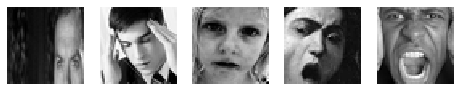

Original w/ Linear Transform to normalize pixel values


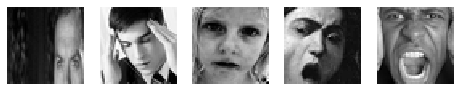

Normalized w/ Contrast Limited Adaptive Histogram Equalization


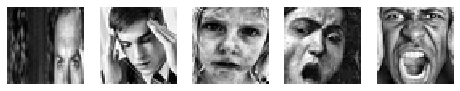

In [27]:
'''
Histogram Equalization - Not defined as method, because 
train has a special case to catch and delete harmful inputs
'''
clahe = cv2.createCLAHE(clipLimit=3.235, tileGridSize=(5,5))

# original image set
X_train1 = X_train.copy() 
X_val1 = X_validation.copy()
X_test1 = X_test.copy()

# linear histogram equalization set
X_train2 = X_train.copy() 
X_val2 = X_validation.copy()
X_test2 = X_test.copy()

# clahe set
X_train3 = X_train.copy()
X_val3 = X_validation.copy()
X_test3 = X_test.copy()

# frontalized set
X_train4 = X_train.copy()
X_val4 = X_validation.copy()
X_test4 = X_test.copy()

# histogram equalization (primarily) for sets 2, 3
i = 0
while (i < num_train):
  tMax = X_train1[i].max()
  tMin = X_train1[i].min()  

  if (tMax > tMin):
    tRatio = 255 / (tMax - tMin)
    X_train2[i] = np.multiply((X_train1[i] - tMin), tRatio)
    
  # Delete harmful training examples from X_train
  else:
    X_train1 = np.delete(X_train1, (i), axis=0)
    X_train2 = np.delete(X_train2, (i), axis=0)
    X_train3 = np.delete(X_train3, (i), axis=0)
    X_train4 = np.delete(X_train4, (i), axis=0)
    y_train = np.delete(y_train, (i), axis=0)
    num_train -= 1
    i -= 1
    
  X_train3[i] = clahe.apply(X_train2[i])[:,:,np.newaxis]
  i += 1
  
i = 0
while (i < num_validation):
  tMax = X_val1[i].max()
  tMin = X_val1[i].min()

  if (tMax > tMin):
    tRatio = 255 / (tMax - tMin)
    X_val2[i] = np.multiply((X_val1[i] - tMin), tRatio).round()
    
  # Shouldn't delete validation data... skip so we don't divide by 0
  else:
    X_val2[i] = X_val1[i]

  X_val3[i] = clahe.apply(X_val2[i])[:,:,np.newaxis]
  i += 1

i = 0
while (i < num_test):
  tMax = X_test1[i].max()
  tMin = X_test1[i].min()

  if (tMax > tMin):
    tRatio = 255 / (tMax - tMin)
    X_test2[i] = np.multiply((X_test1[i] - tMin), tRatio).round()
    
  # Shouldn't delete test data... skip so we don't divide by 0
  else:
    X_test2[i] = X_test1[i]
    
  X_test3[i] = clahe.apply(X_test2[i])[:,:,np.newaxis]
  i += 1
  
# apply frontalization
#print("Attempting to frontalize image data...")
#myfrontalize(X_train4, num_train)
#myfrontalize(X_val4, num_validation)
#myfrontalize(X_test4, num_test)


# print examples from each set
print('Original Images')
for x in range(1,6):
    plt.subplot(1, 5, x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test1[x,:,:,0], cmap='gray')
    
plt.show()

print('Original w/ Linear Transform to normalize pixel values')
for x in range(1,6):
    plt.subplot(1, 5, x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test2[x,:,:,0], cmap='gray')
    
plt.show()

print('Normalized w/ Contrast Limited Adaptive Histogram Equalization')
for x in range(1,6):
    plt.subplot(1, 5, x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test3[x,:,:,0], cmap='gray')
    
plt.show() 

#plt.figure()
#plt.title('Frontalized Images')
#for x in range(1,6):
#  plt.subplot(1, 5, x)
#  plt.xticks([])
#  plt.yticks([])
#  plt.imshow(X_test4[x, :, :, 0], cmap='gray') 
#plt.show()

In [0]:
np.save('X_train_frontalized', X_train4)
np.save('X_val_frontalized', X_val4)
np.save('X_test_frontalized', X_test4)

In [0]:
'''
TensorFlow Model(s)
'''

# shallow model
def get_model1():
  model = Sequential()

  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(256, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model

# actual model
def get_model2():
  model = Sequential()

  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(128, (5, 5), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model

# deeper model
def get_model3():
  model = Sequential()

  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(Convolution2D(64, (3, 3), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  #model.add(GaussianNoise(2))
  model.add(Dropout(0.4))

  model.add(Convolution2D(128, (3, 3), padding='same'))
  model.add(Convolution2D(128, (3, 3), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  #model.add(GaussianNoise(2))
  model.add(Dropout(0.4))

  model.add(Convolution2D(256, (3, 3), padding='same'))
  model.add(Convolution2D(265, (3, 3), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  #model.add(GaussianNoise(2))
  model.add(Dropout(0.4))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(Convolution2D(512, (3, 3), padding='same')) 
  model.add(Convolution2D(512, (1, 1), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  #model.add(GaussianNoise(2))
  model.add(Dropout(0.4))

  model.add(Flatten())

  model.add(Dense(2048))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.4))

  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.4))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model

In [0]:
'''
Metric(s)
'''

# metric to balance precision and recall
def fbeta(y_true, y_pred, threshold_shift=0):
  beta = 1

  # just in case of hipster activation at the final layer
  y_pred = K.clip(y_pred, 0, 1)

  # shifting the prediction threshold from .5 if needed
  y_pred_bin = K.round(y_pred + threshold_shift)

  tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
  fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
  fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

  precision = tp / (tp + fp)
  recall = tp / (tp + fn)

  beta_squared = beta ** 2
  return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))


In [28]:
'''
Prepare Model for Training
'''
# assign the desired model from above
model = get_model1()
model.summary()

# assign X to the desired image set(s) from above
X_train = X_train3.copy()
X_validation = X_val3.copy()
X_test = X_test3.copy()

num_train = len(X_train)

# reshape X to expected shape and cast it back to type float32
X_train = X_train.reshape(num_train,width,height,depth).astype(np.float32)
X_validation = X_validation.reshape(num_validation,width,height,depth).astype(np.float32)
X_test = X_test.reshape(num_test,width,height,depth).astype(np.float32)

# augment and fit data
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0,
    zoom_range=0.0,
    horizontal_flip=True,
    vertical_flip=False)
datagen.fit(X_train)
datagen.fit(X_validation)

# to be applied during training
checkpointer = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, 
    save_best_only=False, mode='auto')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, 
    patience=10, verbose=0, mode='auto', 
    min_delta=0.0001, cooldown=0, min_lr=0)
early_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, 
    verbose=0, mode='auto')

# prepare model to train
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=[fbeta, 'accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_19 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_22 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_20 (Batc (None, 24, 24, 128)       512       
__________

In [29]:
'''
Training
'''
train_flow = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_flow = datagen.flow(X_validation, y_validation)

history = model.fit_generator(
    train_flow,
    steps_per_epoch= num_train / BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_data=validation_flow,
    validation_steps=num_validation / BATCH_SIZE,
    callbacks=[checkpointer, reduce_lr, checkpointer]
)

Epoch 1/128
225/224 [==============================] - 28s 127ms/step - loss: 1.7023 - fbeta: 0.1670 - acc: 0.3553 - val_loss: 1.4703 - val_fbeta: 0.2241 - val_acc: 0.4256

Epoch 00001: saving model to Model.01-0.4256.hdf5

Epoch 00001: saving model to Model.01-0.4256.hdf5
Epoch 2/128
225/224 [==============================] - 23s 102ms/step - loss: 1.3823 - fbeta: 0.2653 - acc: 0.4700 - val_loss: 2.1002 - val_fbeta: 0.2532 - val_acc: 0.3308

Epoch 00002: saving model to Model.02-0.3308.hdf5

Epoch 00002: saving model to Model.02-0.3308.hdf5
Epoch 3/128
225/224 [==============================] - 23s 101ms/step - loss: 1.2614 - fbeta: 0.3118 - acc: 0.5199 - val_loss: 1.2370 - val_fbeta: 0.2953 - val_acc: 0.5259

Epoch 00003: saving model to Model.03-0.5259.hdf5

Epoch 00003: saving model to Model.03-0.5259.hdf5
Epoch 4/128
225/224 [==============================] - 23s 102ms/step - loss: 1.1950 - fbeta: 0.3476 - acc: 0.5427 - val_loss: 1.1869 - val_fbeta: 0.3441 - val_acc: 0.5505

Epoch

28/28 [==============================] - 17s 615ms/step
Evaluation Loss:  1.0511407852172852
Evaluation Accuracy:  0.6575647592544556


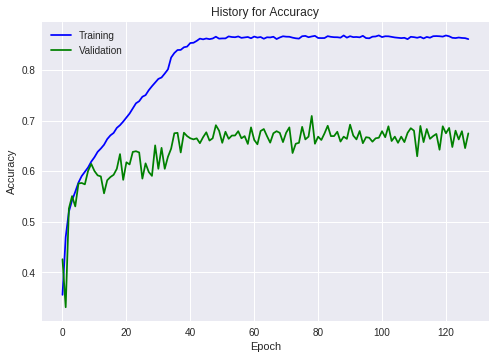

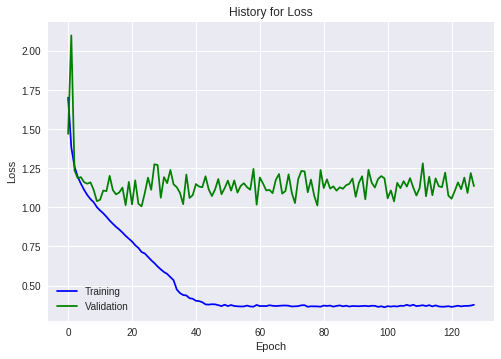

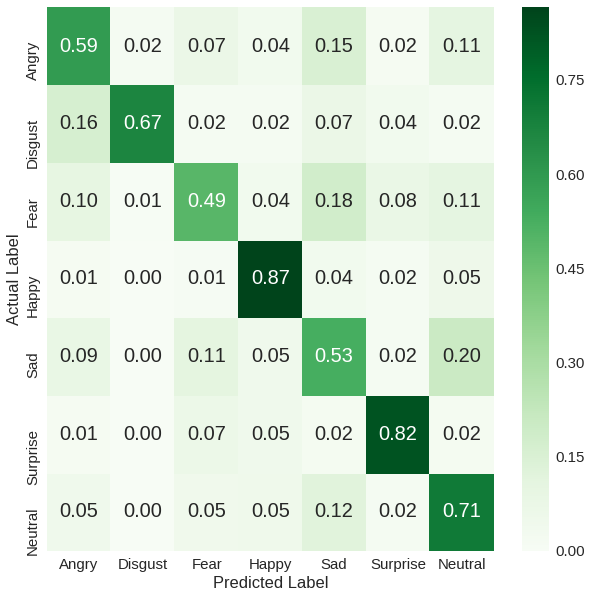

In [31]:
'''
Evaluate Test Set & Print Results
'''
score = model.evaluate(X_test, y_test, steps=int(num_test / BATCH_SIZE))
print('Evaluation Loss: ', score[0])
print('Evaluation Accuracy: ', score[1])

# History of Accuracy
fig1 = plt.figure()
plt.plot(history.history['acc'], color='b', label='Training')
plt.plot(history.history['val_acc'], color='g', label='Validation')
plt.title('History for Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig(acc_file)
plt.show() 

# History of Loss
fig2 = plt.figure()
plt.plot(history.history['loss'], color='b', label='Training')
plt.plot(history.history['val_loss'], color='g', label='Validation')
plt.title('History for Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
fig2.savefig(loss_file)
plt.show()

# Confusion Matrix
y_pred = model.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    cm_norm, annot=True, linewidths=0, square=False, cmap='Greens', 
    yticklabels=emotion_labels, xticklabels=emotion_labels, 
    vmin=0, vmax=np.max(cm_norm), fmt='.2f', 
    annot_kws={'size': 20}
)
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.savefig(cm_file)
plt.show()